## Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments



In [1]:
import sys
print(sys.version)

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [44]:
import sklearn
import pandas as pd
import re

import wordcloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
import time

In [3]:
dirName = "/Users/jessicaaddai/Downloads/"
fileName = "Food_Inspections.csv"
pathName = dirName + fileName 


In [4]:
df = pd.read_csv(pathName)
df.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2559389,LOS DOS ARTUROS,NaN,2850963.0,NaN,All,2825 W CERMAK RD,CHICAGO,IL,60623.0,06/15/2022,License,Not Ready,NaN,41.851778,-87.696588,"(-87.69658765547098, 41.85177848071863)"
1,2556920,BISTRO,BISTRO,2846049.0,Restaurant,Risk 1 (High),1400 S JEAN BAPTISTE POINTE DUSABLE LAKESHORE DR,CHICAGO,IL,60605.0,06/07/2022,License,Pass,NaN,NaN,NaN,NaN
2,2555141,10 SOUTH MARKET,10 SOUTH MARKET,2845404.0,NaN,All,10 S LA SALLE ST LBBY,CHICAGO,IL,60603.0,05/03/2022,License,Not Ready,NaN,41.881675,-87.632504,"(-87.63250418895821, 41.88167475683708)"
3,2549752,MOMOTARO,MOMOTARO,2319777.0,Restaurant,Risk 1 (High),820 W LAKE ST,CHICAGO,IL,60607.0,02/14/2022,Non-Inspection,No Entry,NaN,41.885758,-87.648411,"(-87.64841058851927, 41.88575836898289)"
4,2549607,Buyk,Buyk,2831377.0,NaN,Risk 3 (Low),3621 N WESTERN AVE,CHICAGO,IL,60618.0,02/09/2022,License,Not Ready,NaN,41.947389,-87.688130,"(-87.68813004392258, 41.94738858055078)"
5,2546282,MEZCALINA,MEZCALINA,2138371.0,Restaurant,Risk 1 (High),333 E BENTON PL,CHICAGO,IL,60601.0,01/07/2022,Canvass,Out of Business,NaN,41.885390,-87.618987,"(-87.61898671163952, 41.88539004666972)"
6,2545752,EXXON,EXXON,2817855.0,Grocery Store,Risk 3 (Low),3202 W CERMAK RD,CHICAGO,IL,60623.0,12/16/2021,License,Pass,NaN,41.851873,-87.705387,"(-87.7053867838598, 41.85187305783481)"
7,2545669,MIXTECO GRILL #3 LLC,MIXTECO GRILL #3 LLC,2823196.0,Restaurant,Risk 1 (High),1209-11 N NOBLE ST,CHICAGO,IL,60642.0,12/15/2021,License,Pass,NaN,41.903725,-87.662474,"(-87.66247406362302, 41.90372547737016)"
8,2545639,MR. WANG,MR. WANG,2283505.0,Restaurant,Risk 1 (High),2171 S CHINA PL,CHICAGO,IL,60616.0,12/15/2021,Canvass,Out of Business,NaN,41.853523,-87.635267,"(-87.63526698031632, 41.85352288328991)"
9,2545602,NIAGARA,NIAGARA,2766718.0,NaN,All,2658 1/2 W DEVON AVE,CHICAGO,IL,60659.0,12/14/2021,Canvass,Out of Business,NaN,41.997713,-87.697148,"(-87.69714822634178, 41.99771304677634)"


In [5]:
df.shape

(237663, 17)

In [6]:
df = df[df['Violations'].notna()]
df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
46,2522310,SOCIAL JUNKIE,SOCIAL JUNKIE,2551384.0,Restaurant,Risk 1 (High),3848 N HARLEM AVE,CHICAGO,IL,60634.0,07/02/2021,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.950348,-87.807329,"(-87.80732944580947, 41.95034769269968)"
54,2521227,FURIOUS SPOON,FURIOUS SPOON,2551072.0,Restaurant,Risk 1 (High),800 W BELMONT AVE,CHICAGO,IL,60657.0,06/11/2021,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.940090,-87.649310,"(-87.64930995909579, 41.94009012484825)"
86,2501015,HAI YEN,HAI YEN,10235.0,Restaurant,Risk 1 (High),1055 W ARGYLE ST,CHICAGO,IL,60640.0,05/03/2021,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.973172,-87.657141,"(-87.65714083118823, 41.97317176563255)"
93,2500361,"CHAN'S KING WOK, INC",KING WOK,2320986.0,Restaurant,Risk 1 (High),2323 W MADISON ST,CHICAGO,IL,60612.0,04/16/2021,Complaint,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.881075,-87.684924,"(-87.6849240911884, 41.88107532038358)"
101,2498179,LITTLE CAESAR PIZZA #1643,LITTLE CAESAR 'S PIZZA,2222.0,Restaurant,Risk 2 (Medium),5608 W IRVING PARK RD,CHICAGO,IL,60634.0,04/13/2021,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.953286,-87.767379,"(-87.76737907014223, 41.95328648540001)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237654,68173,MCDONALD' S # 5618,MCDONALD' S # 5618,1960250.0,Restaurant,Risk 2 (Medium),3620 N CLARK ST,CHICAGO,IL,60613.0,02/05/2010,Suspected Food Poisoning,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.947712,-87.657094,"(-87.65709387286819, 41.94771192275855)"
237657,158348,WALGREENS #03074,WALGREENS #03074,2003201.0,Grocery Store,Risk 3 (Low),4700 S HALSTED ST,CHICAGO,IL,60609.0,03/04/2010,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.808815,-87.645683,"(-87.64568295315186, 41.808815039296086)"
237659,112313,Jones Academy High School,Jones Academy High School,2132.0,School,Risk 1 (High),606 S STATE ST,CHICAGO,IL,60605.0,02/16/2010,Canvass,Pass w/ Conditions,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.874419,-87.627755,"(-87.6277549673946, 41.874418979889214)"
237660,74261,CHICAGO STEAKHOUSE,CHICAGO STEAKHOUSE,1954381.0,Restaurant,Risk 2 (Medium),219 E 47TH ST,CHICAGO,IL,60653.0,01/06/2010,Complaint,Fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.809214,-87.620308,"(-87.62030817634384, 41.809213860173834)"


In [7]:
df.Results.value_counts()

Pass                  94063
Fail                  42642
Pass w/ Conditions    36077
No Entry                586
Not Ready                69
Out of Business          36
Name: Results, dtype: int64

#### Extracting comments from inspectors

In [8]:

def comments(row):
    comments = re.findall('(?<=Comments: )(.*?)(?=\||$)', row.Violations)
    row['Violation_Comments'] = ",".join(comments)
    return row

In [9]:
df = df.apply(comments, axis=1)


In [10]:
df.sample(30)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation_Comments
98774,1977132,DERICE ASIAN CUSINE,DERICE ASIAN CUSINE,1516927.0,Restaurant,Risk 1 (High),918-920 E 47TH ST,CHICAGO,IL,60653.0,12/14/2016,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.809682,-87.603166,"(-87.60316573540783, 41.80968241612921)",CLEAN SURFACE AREA AROUND WOKS AT WOK STATION....
60834,2268220,PLAMONDON ELEMENTARY,PLAMONDON ELEMENTARY,24981.0,School,Risk 1 (High),2642 W 15th Place (1532S),CHICAGO,IL,60608.0,02/20/2019,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.860287,-87.692505,"(-87.6925046809117, 41.86028667955628)",OBSERVED THE BOYS BASEMENT 1ST. HANDSINK PUSH ...
161546,1228340,"TORTILLERIA ATOTONILCO, INC","TORTILLERIA ATOTONILCO, INC",7722.0,Wholesale,Risk 2 (Medium),1707 W 47TH ST,CHICAGO,IL,60609.0,12/02/2013,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.808469,-87.667727,"(-87.6677274811442, 41.80846879520972)",FLOORS IN FRONT RETAIL AREA IN NEED OF CLEANIN...
2819,1516064,CHICAGO'S FINEST,CHICAGO'S FINEST,2327889.0,Mobile Food Preparer,Risk 2 (Medium),324 N LEAVITT ST,CHICAGO,IL,60612.0,01/20/2015,License,Fail,"10. SEWAGE AND WASTE WATER DISPOSAL, NO BACK S...",41.887434,-87.681849,"(-87.68184949426895, 41.88743405025222)",LEAK AT SPIGOT FROM WASTE WATER DRAIN. MUST C...
200633,539614,POL-MART DELI INC,POL-MART,62821.0,grocery & restaurant,Risk 1 (High),7141 W ADDISON ST,CHICAGO,IL,60634.0,01/27/2012,Canvass,Pass w/ Conditions,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.945191,-87.804997,"(-87.80499730288055, 41.945191110996866)",All cold food shall be stored at a temperature...
7024,2553389,Judson & Moore Tavern,JUDSON & MOORE AMERICAN WHISKEY,2823314.0,TAVERN,Risk 3 (Low),3057 N ROCKWELL ST,CHICAGO,IL,60618.0,03/24/2022,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.937395,-87.692738,"(-87.69273768966114, 41.93739494901925)",OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY ON ...
168843,1092656,DICK'S LAST RESORT,DICK'S LAST RESORT,1869463.0,Restaurant,Risk 1 (High),315 N DEARBORN ST,CHICAGO,IL,60654.0,10/09/2013,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.887906,-87.629395,"(-87.629394698683, 41.88790616130565)",RUSTY SHELVES INSIDE WALK-IN COOLER AND IN DRY...
13812,2537280,HARVARD ELEMENTARY SCHOOL,HARVARD ELEMENTARY SCHOOL,23581.0,School,Risk 1 (High),7525 S Harvard (332W),CHICAGO,IL,60620.0,10/26/2021,Canvass Re-Inspection,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.757335,-87.632700,"(-87.63270008365268, 41.7573347204)","OBSERVED DUST, DIRT AND FOOD DEBRIS ON WINDOW..."
41511,2345695,CIRCLE S MART INC.,CIRCLE S MART,2418830.0,Grocery Store,Risk 1 (High),4757 W NORTH AVE,CHICAGO,IL,60639.0,11/15/2019,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.909518,-87.745960,"(-87.7459604441106, 41.90951797458068)",REPAIR THE SECTION OF DRYWALL ON THE CEILING A...
210066,586195,KIN JAPANESE CUISINE,KIN JAPANESE CUISINE,2073585.0,Restaurant,Risk 1 (High),933 N ASHLAND AVE,CHICAGO,IL,60622.0,08/08/2011,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.898904,-87.667223,"(-87.66722318342336, 41.89890432084078)",All food and non-food contact surfaces of equi...


In [11]:
def results(row):
  if row['Results'] == 'Pass':
    row['results_grouped'] = 1
  elif row['Results'] == 'Pass w/ Conditions':
    row['results_grouped'] = 1
  else:
    row['results_grouped'] = 0
  return row

In [12]:
df = df.apply(results, axis=1)

In [13]:
df.head(30)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation_Comments,results_grouped
46,2522310,SOCIAL JUNKIE,SOCIAL JUNKIE,2551384.0,Restaurant,Risk 1 (High),3848 N HARLEM AVE,CHICAGO,IL,60634.0,07/02/2021,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.950348,-87.807329,"(-87.80732944580947, 41.95034769269968)",OBSERVED NO PERSON IN CHARGE PRESENT WITH CITY...,0
54,2521227,FURIOUS SPOON,FURIOUS SPOON,2551072.0,Restaurant,Risk 1 (High),800 W BELMONT AVE,CHICAGO,IL,60657.0,06/11/2021,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.940090,-87.649310,"(-87.64930995909579, 41.94009012484825)",THE PERSON IN CHARGE DURING THE TIME OF INSPEC...,0
86,2501015,HAI YEN,HAI YEN,10235.0,Restaurant,Risk 1 (High),1055 W ARGYLE ST,CHICAGO,IL,60640.0,05/03/2021,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.973172,-87.657141,"(-87.65714083118823, 41.97317176563255)",OBSERVED NO EMPLOYEE HEALTH POLICY/TRAINING ON...,0
93,2500361,"CHAN'S KING WOK, INC",KING WOK,2320986.0,Restaurant,Risk 1 (High),2323 W MADISON ST,CHICAGO,IL,60612.0,04/16/2021,Complaint,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.881075,-87.684924,"(-87.6849240911884, 41.88107532038358)",OBSERVED NO HAND DRYING DEVICE AT HAND SINK IN...,1
101,2498179,LITTLE CAESAR PIZZA #1643,LITTLE CAESAR 'S PIZZA,2222.0,Restaurant,Risk 2 (Medium),5608 W IRVING PARK RD,CHICAGO,IL,60634.0,04/13/2021,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.953286,-87.767379,"(-87.76737907014223, 41.95328648540001)",OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY ON ...,0
119,2492690,SNACK SHOP RESTAURANT,SNACK SHOP RESTAURANT,2124582.0,Restaurant,Risk 1 (High),452 W PERSHING RD,CHICAGO,IL,60609.0,03/10/2021,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.823668,-87.638295,"(-87.6382950217091, 41.82366771868339)",PIC DOESN'T HAVE A FOOD MANAGERS CERTIFICATE.M...,0
135,2473067,SOCIALE AND CAFE PRESS,SOCIALE,2758272.0,Restaurant,Risk 3 (Low),800 S CLARK ST,CHICAGO,IL,60605.0,01/25/2021,License,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.872164,-87.630756,"(-87.63075577691671, 41.87216439605228)",OBSERVED RESIDUE ON INTERIOR SURFACE OF ICE MA...,1
138,2472990,MUI'S FEIDA BAKERY,MUI'S FEIDA BAKERY,82530.0,Restaurant,Risk 1 (High),2228 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/22/2021,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.852069,-87.632143,"(-87.63214293138071, 41.852068812871245)",NO EMPLOYEE HEALTH POLICY ON PREMISES AS REQU...,0
142,2472812,FIN SUSHI BAR,FIN SUSHI BAR,2079332.0,Restaurant,Risk 1 (High),1742 W WILSON AVE,CHICAGO,IL,60640.0,01/19/2021,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.965300,-87.672592,"(-87.67259229705587, 41.965299735031415)",NO SOAP PROVIDED AT HANDWASHING SINK AT SUSHI ...,0
152,2472459,MCDONALD'S #10720,MCDONALD'S,2551030.0,Restaurant,Risk 2 (Medium),7832 S WESTERN AVE,CHICAGO,IL,60620.0,01/08/2021,Complaint,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.750932,-87.683018,"(-87.68301753189526, 41.75093165729936)",INSTRUCTED MANAGER TO CLEAN THE INTERIOR OF TH...,1


In [14]:
df.Results.value_counts()


Pass                  94063
Fail                  42642
Pass w/ Conditions    36077
No Entry                586
Not Ready                69
Out of Business          36
Name: Results, dtype: int64

In [15]:
#Checking to see if values match up to Results
df.results_grouped.value_counts()

1    130140
0     43333
Name: results_grouped, dtype: int64

In [16]:
list(df.Violation_Comments)[0]

"OBSERVED NO PERSON IN CHARGE PRESENT WITH CITY OF CHICAGO CERTIFIED MANAGER CERTIFICATE. ,OBSERVED NO CERTIFIED FOOD MANAGER ON SITE WHILE (TCS FOODS) (HAMBURGERS,SANDWICHES ETC.) ARE BEING PREPARED AND SERVED TO THE CUSTOMERS. INSTRUCTED PERSON IN CHARGE, A CERTIFIED FOOD MANAGER WITH CITY OF CHICAGO FOODSERVICE SANITATION CERTIFICATE MUST BE PRESENT WHEN HANDLING (TCS FOODS).PRIORITY FOUNDATION VIOLATION 7-38-012,CITATION ISSUED. ,OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY ON THE PREMISES. MANAGEMENT INSTRUCTED TO PROVIDE A SIGNED EMPLOYEE HEALTH POLICY FOR EACH EMPLOYEE. PRIORITY FOUNDATION VIOLATION 7-38-010, NO CITATION ISSUED. ,OBSERVED NO PROCEDURE/PLAN FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTRUCTED TO PROVIDE AND MAINTAIN REQUIRED PROCEDURE/PLAN AND APPROPRIATE SUPPLIES OR KIT. (NECESSARY ITEMS AT A MINIMUM: GLOVES, FACE MASKS, DISPOSABLE MOPS, AND APPROPRIATE SANITIZER/SPRAY THAT IS EFFECTIVE AGAINST NOROVIRUS). PRIORITY FOUNDATION VIOLATION 7-38-005, NO CITATION

In [17]:
list(df.results_grouped)[0]

0

#### CountVectorizer

In [18]:
X = df.Violation_Comments
y = df.results_grouped

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(130104,)
(43369,)
(130104,)
(43369,)


In [19]:
start_time = time.time()
countvectorizer = CountVectorizer()
countvectorizer_matrix = countvectorizer.fit_transform(X_train)
print(countvectorizer_matrix.shape)
print("%s seconds" % (time.time() - start_time))

(130104, 43443)
8.123280048370361 seconds


In [20]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names())
countvectorizer_matrix_df

,00,000,000058030,000058831,000063465,000072748,000083332,0001,0005,0005a,...,½e,½ed,½f,½facility,½held,½o,½observed,½time,½tons,½ï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Removing stop-words from CountVectorizer and controlling features

In [21]:
countvectorizer = CountVectorizer(stop_words='english',
                                   max_features=2000, ngram_range=(1,3))
countvectorizer_matrix = countvectorizer.fit_transform(X_train)
countvectorizer_matrix.shape

(130104, 2000)

In [22]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names())
countvectorizer_matrix_df

,00,005,005 citation,005 citation issued,005 observed,005a,010,010 citation,010 citation issued,012,...,women washroom,womens,wood,work,working,worn,worth,written,written employee,written employee health
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,2,2,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
130102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_test_cv = countvectorizer.fit_transform(X_test)


In [24]:
X_test_cv.shape

(43369, 2000)

#### TfidfVectorizer

In [25]:
tfidfvectorizer = TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,3))
tfidfvectorizer_matrix = tfidfvectorizer.fit_transform(X_train)
tfidfvectorizer_matrix.shape

(130104, 2000)

In [26]:
tfidfvectorizer_matrix

<130104x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 10880706 stored elements in Compressed Sparse Row format>

In [27]:
X_test_tfidf = tfidfvectorizer.fit_transform(X_test)
X_test_tfidf.shape

(43369, 2000)

# Modeling 

### Naive Bayes - Countvectorizer


In [28]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [29]:
# train and time the model using countvectorizer_matrix
%time nb.fit(countvectorizer_matrix, y_train)

CPU times: user 38.3 ms, sys: 53.6 ms, total: 91.9 ms
Wall time: 143 ms


MultinomialNB()

In [30]:
countvectorizer_matrix.shape

(130104, 2000)

In [31]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_cv)

In [32]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 73.8%


In [33]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.49      0.84      0.62     10985
           1       0.93      0.70      0.80     32384

    accuracy                           0.74     43369
   macro avg       0.71      0.77      0.71     43369
weighted avg       0.82      0.74      0.75     43369



In [34]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 9238  1747]
 [ 9636 22748]]


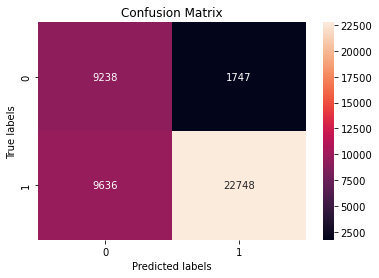

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(y_test, y_pred_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [46]:
def roc_curve_plot(y_test_, y_pred_class):
    roc_score = roc_auc_score(y_test_, y_pred_class)
    fpr, tpr, thresholds = roc_curve(y_test_, y_pred_class)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

roc_auc_score---  0.7717053021907344


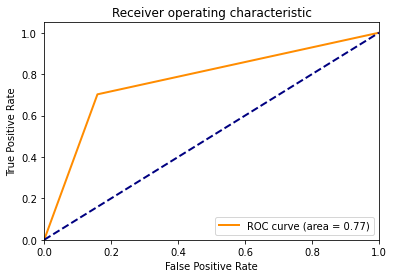

In [49]:

print("roc_auc_score--- ", roc_auc_score(y_test, y_pred_class))
roc_curve_plot(y_test, y_pred_class)


### Logistic Regression - Countvectorizer

In [51]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [52]:
# train the model using countvectorizer_matrix
%time logreg.fit(countvectorizer_matrix, y_train)

CPU times: user 22.8 s, sys: 192 ms, total: 23 s
Wall time: 23.1 s


LogisticRegression(max_iter=10000)

In [53]:
# make class predictions for X_test_cv
y_pred_class = logreg.predict(X_test_cv)

In [54]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 78.3%


In [55]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.60      0.44      0.50     10985
           1       0.83      0.90      0.86     32384

    accuracy                           0.78     43369
   macro avg       0.71      0.67      0.68     43369
weighted avg       0.77      0.78      0.77     43369



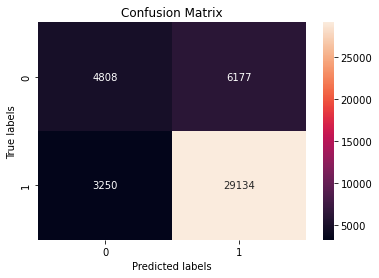

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(y_test, y_pred_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


roc_auc_score---  0.6686647772249619


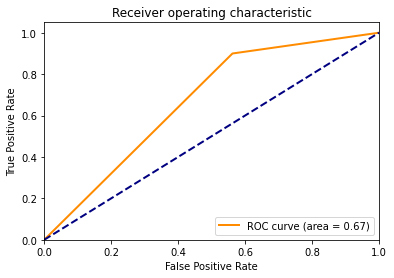

In [58]:
print("roc_auc_score--- ", roc_auc_score(y_test, y_pred_class))
roc_curve_plot(y_test, y_pred_class)

## Naive Bayes - TFIDF

In [59]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [60]:
# train and time the model using tfidfvectorizer_matrix
%time nb.fit(tfidfvectorizer_matrix, y_train)

CPU times: user 56.2 ms, sys: 65.1 ms, total: 121 ms
Wall time: 149 ms


MultinomialNB()

In [61]:
# make class predictions for X_test_tfidf
y_pred_class = nb.predict(X_test_tfidf)

In [62]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 83.2%


In [63]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65     10985
           1       0.87      0.90      0.89     32384

    accuracy                           0.83     43369
   macro avg       0.78      0.76      0.77     43369
weighted avg       0.83      0.83      0.83     43369



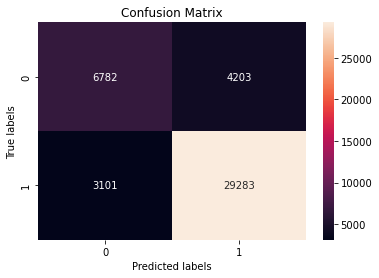

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(y_test, y_pred_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


roc_auc_score---  0.7608150911749043


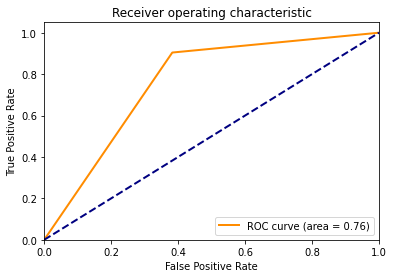

In [65]:
print("roc_auc_score--- ", roc_auc_score(y_test, y_pred_class))
roc_curve_plot(y_test, y_pred_class)

### Logistic Regression - TFIDF

In [66]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [67]:
# train the model using tfidfvectorizer_matrix
%time logreg.fit(tfidfvectorizer_matrix, y_train)

CPU times: user 3.18 s, sys: 16.6 ms, total: 3.19 s
Wall time: 3.2 s


LogisticRegression(max_iter=10000)

In [68]:
# make class predictions for X_test_tfidf
y_pred_class = logreg.predict(X_test_tfidf)

In [69]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 84.7%


In [70]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.45      0.60     10985
           1       0.84      0.98      0.91     32384

    accuracy                           0.85     43369
   macro avg       0.87      0.72      0.75     43369
weighted avg       0.85      0.85      0.83     43369



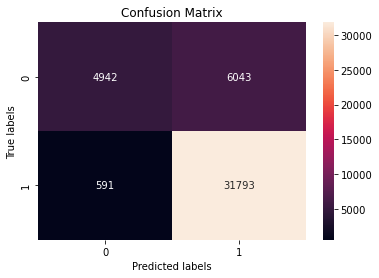

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(y_test, y_pred_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

roc_auc_score---  0.7158182277508317


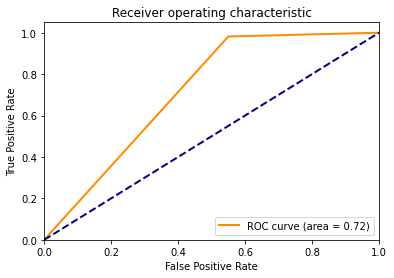

In [72]:
print("roc_auc_score--- ", roc_auc_score(y_test, y_pred_class))
roc_curve_plot(y_test, y_pred_class)

#### Explanation on why a particular text pre-processing technique was selected






Countvectorizer and TFIDF were selected as particular pre-processing techniques and Logistic Regression and Naive Bayes were used for modeling. Countvectorizer was chosen because it allows for conversion of text (inspector comments in this case) to a matrix of token counts. It gives the number of frequency with respect to vocabulary index. TFIDFvectorizer was chosen because I wanted to consider the overall weightage of the document and penalizes frequently used terms while giving higher weights to rarer terms. 

With countvectorizer, Logistic regression performed better than Naive Bayes. With TFIDF, the test accuracies were close with Logistic regression performing slightly better than Naive Bayes. In comparison of both countvectorizer and TFIDF, TFIDF's accuracy outperformed countvectorizer overall. Hence, TFIDF is more robust in my opinion especially since it saves time (looking at the logistic regression time comparison). 